In [1]:
suppressPackageStartupMessages({
    library(monocle)

    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(reshape2)
    library(scales)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [2]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] scales_0.4.1        reshape2_1.4.2      dplyr_0.7.1        
 [4] RColorBrewer_1.1-2  monocle_2.3.5       DDRTree_0.1.5      
 [7] irlba_2.2.1         VGAM_1.0-3          ggplot2_2.2.1      
[10] Biobase_2.30.0      BiocGenerics_0.16.1 Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bindr_0.1              plyr_1

In [3]:
system("mkdir -p RData")
system("mkdir -p tables")

In [4]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

load("RData/YA.cell.type.id.RData")

In [4]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/C.elegans.WB253.gene.id.to.symbol",
    destfile = "RData/C.elegans.WB253.gene.id.to.symbol.tsv")

In [5]:
gene.symbols = read.table(
    "RData/C.elegans.WB253.gene.id.to.symbol.tsv",
    col.names = c("gene", "symbol"), colClasses = rep("character", 2))

rownames(gene.symbols) = gene.symbols$gene

In [6]:
mm.to.mat = function(mm.path, gene.annotation.path, cell.annotation.path, gene.symbols) {
    df = read.table(
        mm.path,
        sep = ",",
        col.names = c("gene.idx", "cell.idx", "count"),
        colClasses = c("integer", "integer", "integer"))
    
    mat = sparseMatrix(i = df$gene.idx, j = df$cell.idx, x = df$count)
    
    gene.annotations = read.csv(
        gene.annotation.path,
        col.names = c("gene", "gene.type", "exon.intron", "symbol", "gene.idx"), header=F)
    
    cell.annotations = read.table(
        cell.annotation.path, sep = ",",
        col.names = c("cell", "cell.idx"))
    
    rownames(mat) = as.character(gene.annotations$gene)
    colnames(mat) = as.character(cell.annotations$cell)
    
    mat.exon = mat[gene.annotations$exon.intron == "exon",]
    mat.intron = mat[gene.annotations$exon.intron == "intron",]
    nrow(mat.exon) == nrow(mat.intron)
    mat = mat.exon + mat.intron
    mat = mat[order(rownames(mat)),]
    rm(list=c("df", "mat.exon", "mat.intron"))
    
    mat = mat[rownames(mat) %in% rownames(gene.symbols),]
}

In [7]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_1/count.mm",
    destfile = "RData/YA.gonad.plate.1.count.mm")

In [8]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_1/gene.annotations.tsv",
    destfile = "RData/YA.gonad.plate.1.gene.annotations.tsv")

In [9]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_1/cell.annotations.tsv",
    destfile = "RData/YA.gonad.plate.1.cell.annotations.tsv")

In [10]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_2/count.mm",
    destfile = "RData/YA.gonad.plate.2.count.mm")

In [11]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_2/gene.annotations.tsv",
    destfile = "RData/YA.gonad.plate.2.gene.annotations.tsv")

In [12]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/YA_gonad/plate_2/cell.annotations.tsv",
    destfile = "RData/YA.gonad.plate.2.cell.annotations.tsv")

In [13]:
plate.1.mat = mm.to.mat(
    "RData/YA.gonad.plate.1.count.mm",
    "RData/YA.gonad.plate.1.gene.annotations.tsv",
    "RData/YA.gonad.plate.1.cell.annotations.tsv",
    gene.symbols)

In [14]:
plate.2.mat = mm.to.mat(
    "RData/YA.gonad.plate.2.count.mm",
    "RData/YA.gonad.plate.2.gene.annotations.tsv",
    "RData/YA.gonad.plate.2.cell.annotations.tsv",
    gene.symbols)

In [15]:
plate.1.cells = colnames(plate.1.mat)
plate.2.cells = colnames(plate.2.mat)

In [16]:
mat = cbind(plate.1.mat, plate.2.mat)
rm(list = c("plate.1.mat", "plate.2.mat"))

In [17]:
pd = new("AnnotatedDataFrame", data = data.frame(
    cell = colnames(mat),
    row.names = colnames(mat),
    n.umi = colSums(mat)))
        
fd = new("AnnotatedDataFrame", data = data.frame(
    gene = gene.symbols$gene,
    symbol = gene.symbols$symbol,
    row.names = gene.symbols$gene))

cds = newCellDataSet(mat, phenoData = pd, featureData = fd, expressionFamily = negbinomial.size())
rm(list = c("mat", "pd", "fd"))

In [18]:
pData(cds)$plate = ifelse(colnames(cds) %in% plate.1.cells, "Plate 1", ifelse(
    colnames(cds) %in% plate.2.cells, "Plate 2", NA))

In [19]:
pData(cds) %>% group_by(plate) %>% summarize(
    n = n(), med.n.umi = median(n.umi),
    n.gt.200.umi = sum(n.umi >= 200),
    prop.gt.200.umi = n.gt.200.umi / n,
    med.n.umi.given.gt.200.umi = median(n.umi[n.umi >= 200]))

plate,n,med.n.umi,n.gt.200.umi,prop.gt.200.umi,med.n.umi.given.gt.200.umi
Plate 1,8099,407,5336,0.6588468,649
Plate 2,13120,248,7264,0.5536585,546


In [20]:
original.cds = cds
cds = original.cds[, pData(cds)$n.umi >= 200]
dim(cds)

Features  Samples 
   20271    12600

In [21]:
cds = estimateSizeFactors(cds)
cds = estimateDispersions(cds)
cds = detectGenes(cds, 0.1)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Removing 304 outliers


In [27]:
set.seed(42)
cds = reduceDimension(
    cds, max_components = 2, norm_method = "log",
    num_dim = 20, reduction_method = "tSNE",
    verbose = T)

pData(cds)$tsne_1 = reducedDimA(cds)[1,]
pData(cds)$tsne_2 = reducedDimA(cds)[2,]

Remove noise by PCA ...
Reduce dimension by tSNE ...


Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

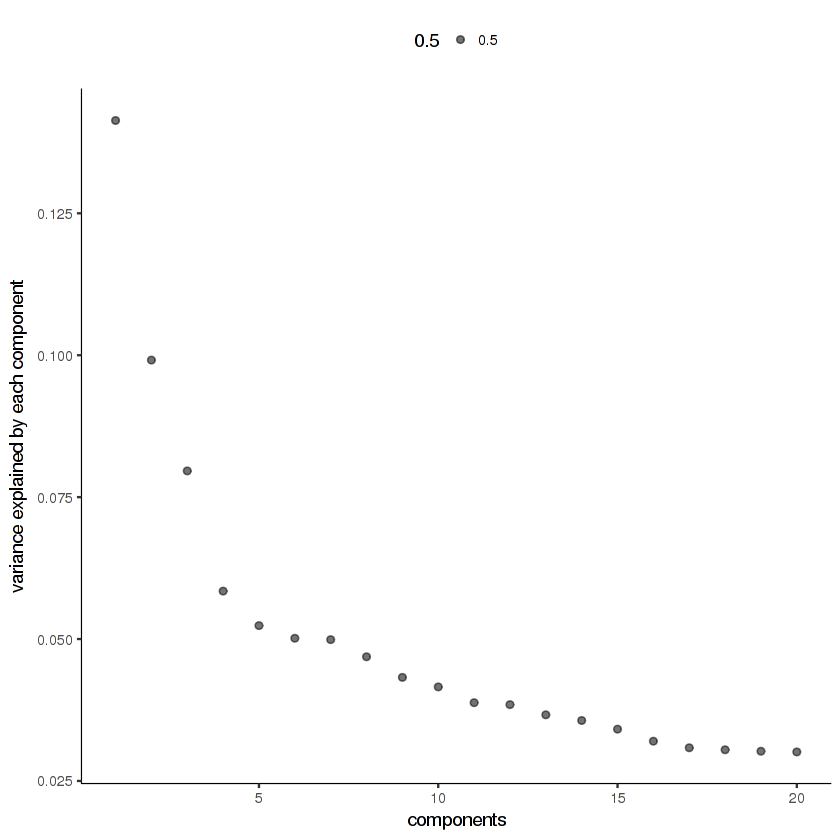

In [28]:
plot_pc_variance_explained(cds)

Distance cutoff calculated to 4.593529 


the length of the distance: 79373700


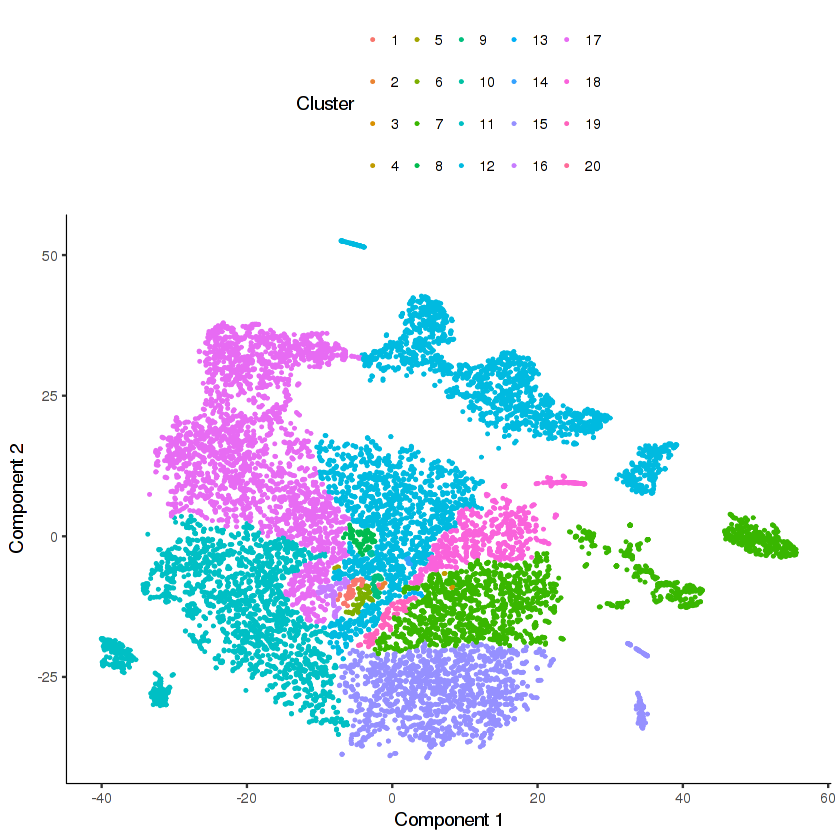

In [29]:
cds = clusterCells_Density_Peak(cds)
plot_cell_clusters(cds, cell_size = 0.333)

Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”

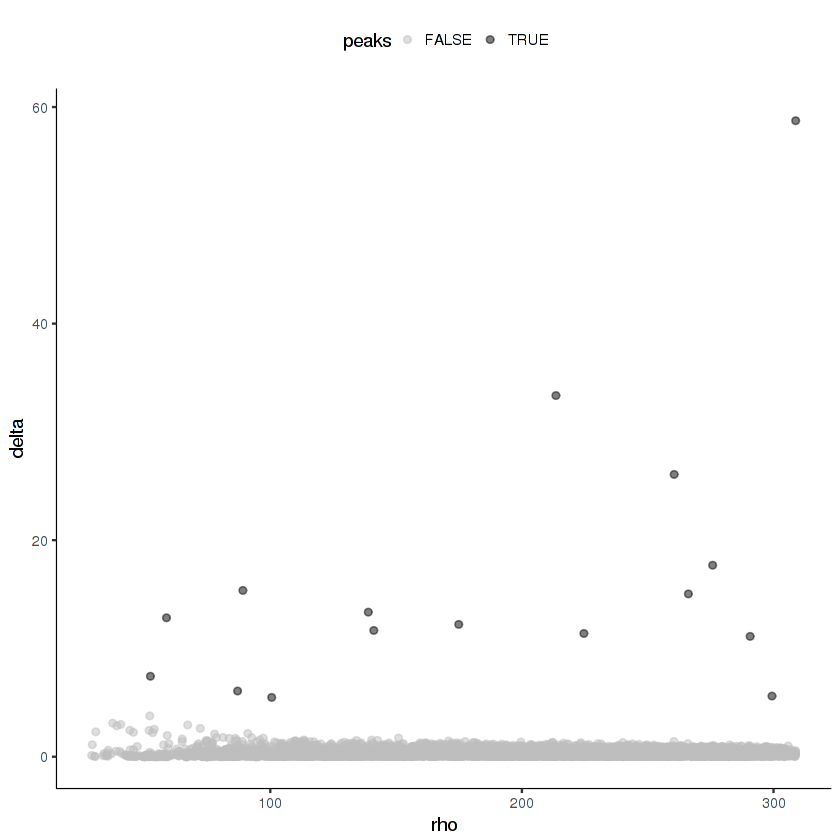

In [30]:
plot_rho_delta(cds, rho_threshold = 10, delta_threshold = 5)

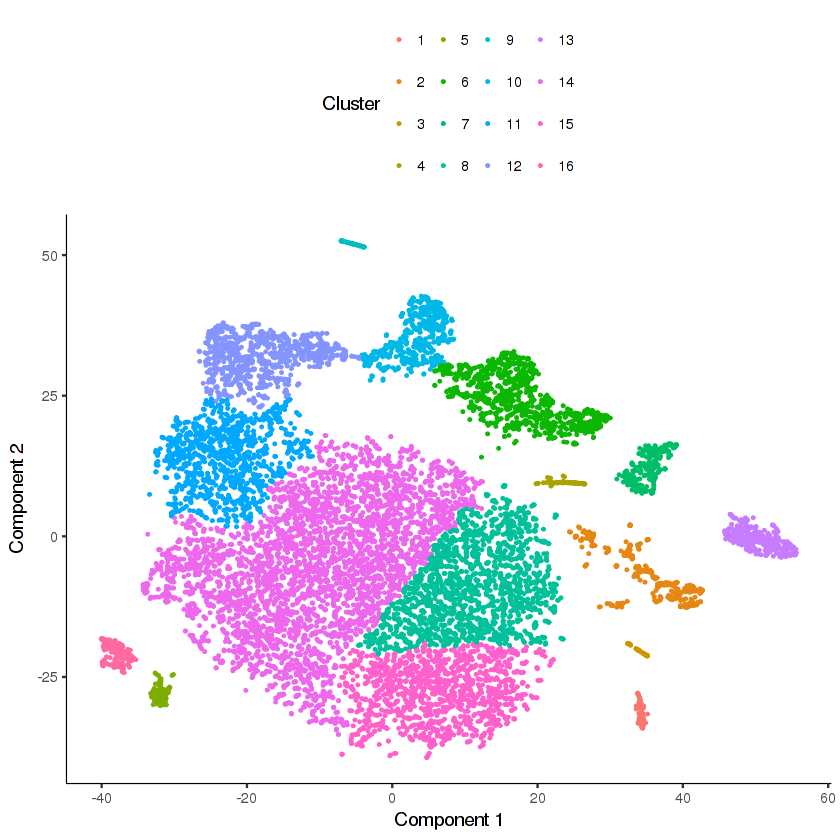

In [31]:
cds = clusterCells_Density_Peak(cds,
    rho_threshold = 10, delta_threshold = 5, skip_rho_sigma = T)
plot_cell_clusters(cds, cell_size = 0.333)

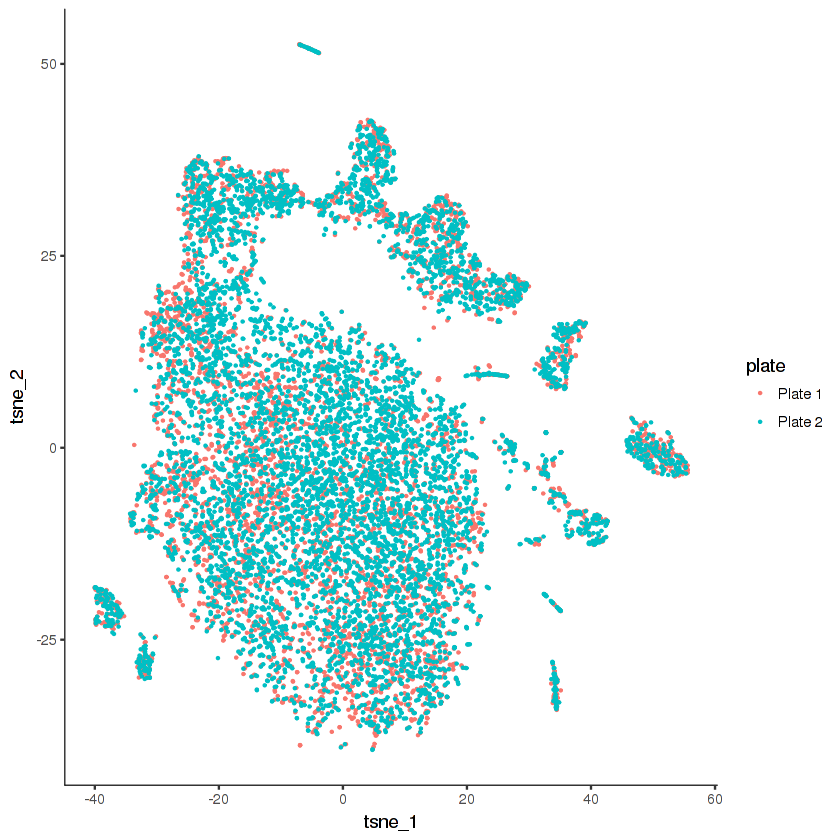

In [32]:
ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = plate)) +
    geom_point(size = 0.2) +
    monocle:::monocle_theme_opts()

In [35]:
get.cluster.markers = function(cds) {    
    cluster_means = lapply(1:length(unique(pData(cds)$Cluster)),
                           function(x) rowMeans(exprs(cds)[, pData(cds)$Cluster == x]))
    cluster_means = t(do.call(rbind, cluster_means))
    colnames(cluster_means) = 1:length(unique(pData(cds)$Cluster))
    specificity_scores = apply(cluster_means, 1, function(x) 1 - sum(x >= 0.1*max(x))/length(x))
    cluster_marker_scores = sweep(cluster_means, 1, specificity_scores^3, "*")
    
    cluster_marker_df = melt(cluster_marker_scores)
    names(cluster_marker_df) = c("gene", "cluster", "score")
    cluster_marker_df = inner_join(cluster_marker_df, fData(cds)[, 1:3], by= "gene") %>%
        group_by(cluster) %>% arrange(-score) %>% mutate(rank = rank(-score)) %>%
        filter(rank <= 100) %>% arrange(cluster, rank)
        
    return(cluster_marker_df)
}

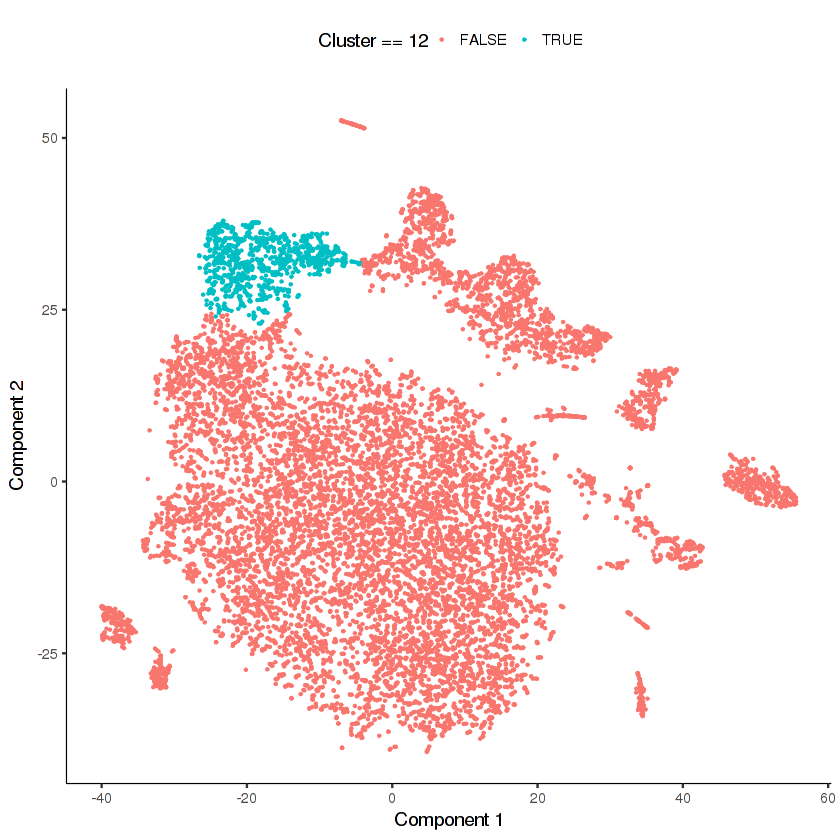

In [66]:
plot_cell_clusters(cds, color = "Cluster == 12", cell_size = 0.2)

In [36]:
cluster.markers = get.cluster.markers(cds)

In [65]:
cluster.markers %>% filter(cluster == 12) %>% head(20)

gene,cluster,score,symbol,num_cells_expressed,rank
WBGene00021605,12,5.3228951,Y46H3C.5,876,1
WBGene00021607,12,4.8922896,Y46H3C.7,858,2
WBGene00021316,12,3.2058335,Y32H12A.8,2922,3
WBGene00020496,12,2.9547347,spat-3,1621,4
WBGene00018193,12,2.6063870,F39C12.1,2186,5
WBGene00016868,12,2.0602232,C52B9.8,777,6
WBGene00010351,12,1.8069996,cbd-1,6017,7
WBGene00021186,12,1.2428099,Y9D1A.1,684,8
WBGene00004053,12,0.9801465,tank-1,1656,9
WBGene00004106,12,0.9447195,pqn-15,590,10


In [38]:
plot.expr = function(cds, gene, thresh=1) {
    gene.id = as.character(fData(cds)[fData(cds)$symbol == gene, "gene"])
    pData(cds)$tmp = exprs(cds)[gene.id,] >= thresh
    plot = ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = tmp)) +
        geom_point(size = 0.2) +
        scale_color_manual(values = c("grey70", "firebrick3")) +
        guides(color = F) +
        monocle:::monocle_theme_opts()
    pData(cds)$tmp = NULL
    return(plot)
}

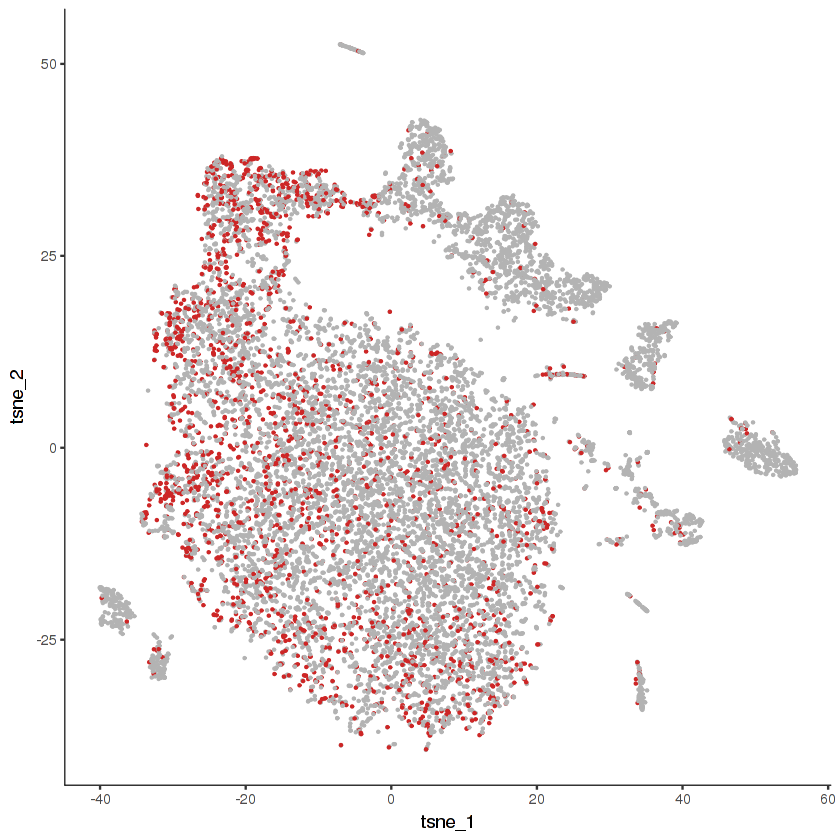

In [64]:
plot.expr(cds, "glp-1")

In [67]:
pData(cds)$cell.type = NA

In [68]:
# glh-1, pgl-1, glp-1
pData(cds)$cell.type = ifelse(pData(cds)$Cluster %in% c(8, 11, 14, 15), "Immature germline", pData(cds)$cell.type)

In [69]:
# ceh-39, meg-1, meg-3
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 12, "Oocytes", pData(cds)$cell.type)

In [70]:
# ssq-2, ssq-4, fer-1
pData(cds)$cell.type = ifelse(pData(cds)$Cluster %in% c(6, 10), "Sperm", pData(cds)$cell.type)

In [71]:
# nmy-1, rhgf-1, no emb-9
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 4, "Spermatheca", pData(cds)$cell.type)

In [72]:
# nmy-1, tbh-1, emb-9
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 7, "Gonad sheath cells", pData(cds)$cell.type)

In [73]:
# myo-3, ttn-1, unc-54, unc-22, unc-89
pData(cds)$cell.type = ifelse(pData(cds)$Cluster %in% c(5, 16), "Body wall muscle", pData(cds)$cell.type)

In [74]:
# myo-1, myo-2
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 3, "Pharyngeal muscle", pData(cds)$cell.type)

In [75]:
# phat-4, phat-3, phat-6
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 9, "Pharyngeal gland", pData(cds)$cell.type)

In [76]:
# cup-4, let-381, mig-6
pData(cds)$cell.type = ifelse(pData(cds)$Cluster == 13, "Coelomocytes", pData(cds)$cell.type)

In [81]:
# Cluster 3 looks to be a mix of hypodermis and glia
# Not sure what Cluster 1 is. It expresses several nematode specific peptide genes. 

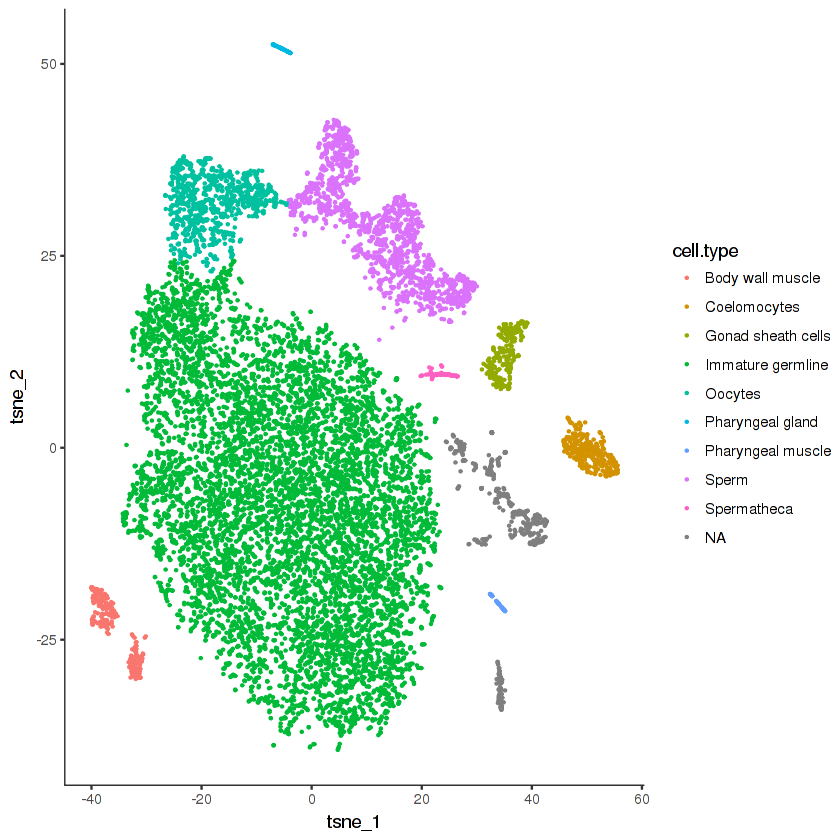

In [77]:
ggplot(pData(cds), aes(x = tsne_1, y = tsne_2, color = cell.type)) +
    geom_point(size = 0.2) +
    monocle:::monocle_theme_opts()

In [92]:
rm(list = c("mm.to.mat", "original.cds", "plate.1.cells", "plate.2.cells", "gene.symbols"))

In [95]:
save.image("RData/YA.cell.type.id.RData")